### TTV analysis assuming Student's t likelihood

This notebook reproduces the TTV analysis of the V1298 Tau system presented in [Livingston et al. (2026)](https://www.nature.com/articles/s41586-025-09840-z). The entire notebook ran in ~20hr using [jnkepler](https://github.com/kemasuda/jnkepler) 0.2.4 and JAX 0.6.2 on an Apple M3 Ultra.

This notebook uses the dataset associated with the published paper, which can be downloaded from the [publisher-hosted permanent URL](https://static-content.springer.com/esm/art%3A10.1038%2Fs41586-025-09840-z/MediaObjects/41586_2025_9840_MOESM2_ESM.csv).

In [1]:
import jax, os
jax_version = jax.__version__
major, minor, patch = (int(x) for x in jax_version.split(".")[:3])
if (major, minor, patch) >= (0, 4, 32):
    print(f"JAX version: {jax_version}")
    os.environ["XLA_FLAGS"] = "--xla_cpu_use_thunk_runtime=false"
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
from jax import config, random
import numpyro, jax
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, init_to_value
config.update('jax_enable_x64', True)
numpyro.set_platform('cpu')
num_chains = 4
numpyro.set_host_device_count(num_chains)
print ('# jax device count:', jax.local_device_count())

JAX version: 0.6.2
# jax device count: 4


In [2]:
from jnkepler.jaxttv import JaxTTV
from jnkepler.jaxttv.infer import ttv_default_parameter_bounds, ttv_optim_curve_fit, scale_pdic
from jnkepler.information import information_from_model_independent_normal
import arviz as az
import corner

In [3]:
import seaborn as sns
sns.set(style='ticks', font_scale=1.6, font='times')
plt.rcParams["figure.figsize"] = (12,6)
from matplotlib import rc
rc('text', usetex=False)

### define tcobs, errorobs, p_init
- lists of length = (# of planets)
- elements of tcobs and errorobs: arrays of transit times and errors for each planet
- elements of p_init: (reasonably) good guesses for planets' mean periods

In [45]:
d = pd.read_csv("v1298tau_transit_times.csv") # timing data in the paper
planets = ['b', 'c', 'd', 'e']
epochs = [jnp.array(d['Epoch'][d.Planet==p]) for p in planets]
tcobs = [jnp.array(d['Time [BJD-2454833]'][d.Planet==p]) for p in planets]
errorobs = [jnp.array(d['Uncertainty [days]'][d.Planet==p]) for p in planets]

t0_init, p_init = [], []
for j in range(4):
    _p, _t0 = np.polyfit(epochs[j], tcobs[j], deg=1)
    t0_init.append(_t0)
    p_init.append(_p)

dt = 0.25
t_start, t_end = 2230., 5545.

jttv = JaxTTV(t_start, t_end, dt, tcobs, p_init, errorobs=errorobs, print_info=True)

# number of transiting planets:    4
# integration starts at:           2230.00
# first transit time in data:      2231.28
# last transit time in data:       5541.22
# integration ends at:             5545.00
# integration time step:           0.2500 (1/32 of innermost period)



### optimization

In [5]:
param_bounds = ttv_default_parameter_bounds(jttv, mmin=3.003e-6, mmax=3.003e-4)

/Users/k_masuda/miniforge3/envs/thunkrt/lib/python3.12/site-packages/jnkepler/jaxttv/infer.py:142: UserWarning: Bounds for cosi/lnode not provided: assuming coplanar orbits.
  warnings.warn(


# running least squares optimization (n_start=1)...
#   start 0: objective=27991240.76 --> 188.23, elapsed=8.6 s
# ------------------------------------------------------------
# best objective over all starts: 188.23 (76 data)
# total elapsed time: 8.6 sec
# ------------------------------------------------------------


/Users/k_masuda/miniforge3/envs/thunkrt/lib/python3.12/site-packages/jnkepler/jaxttv/jaxttv.py:531: UserWarning: using t0 and P from a linear fit to the observed transit times.
  warnings.warn(


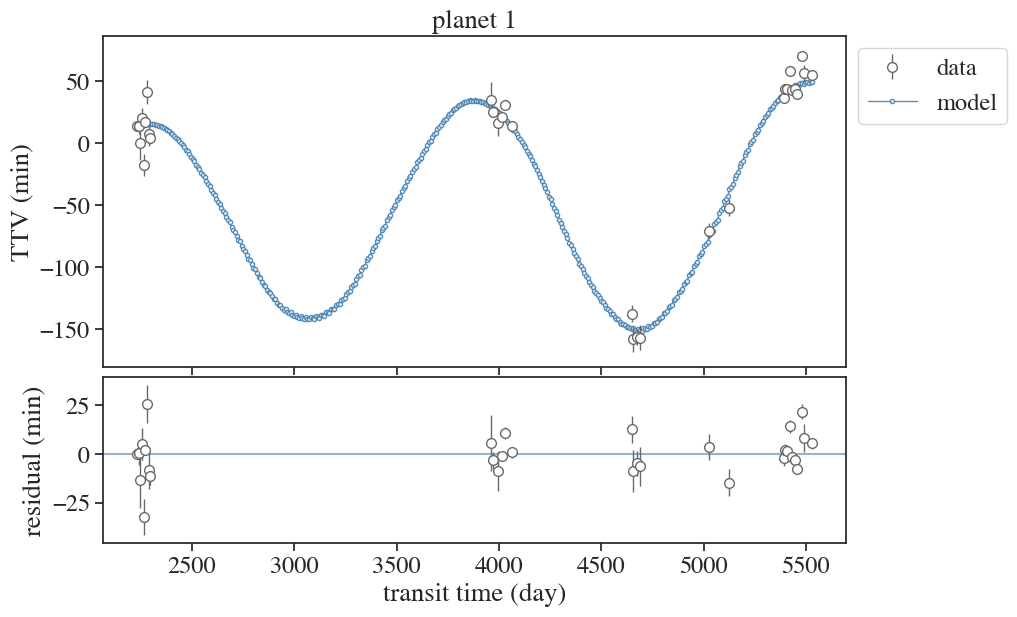

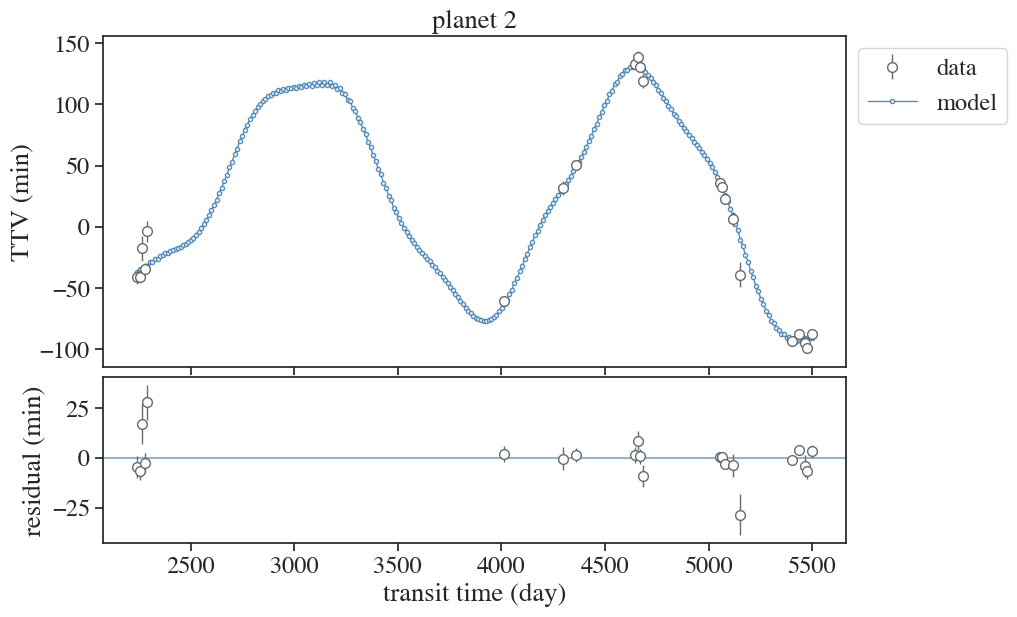

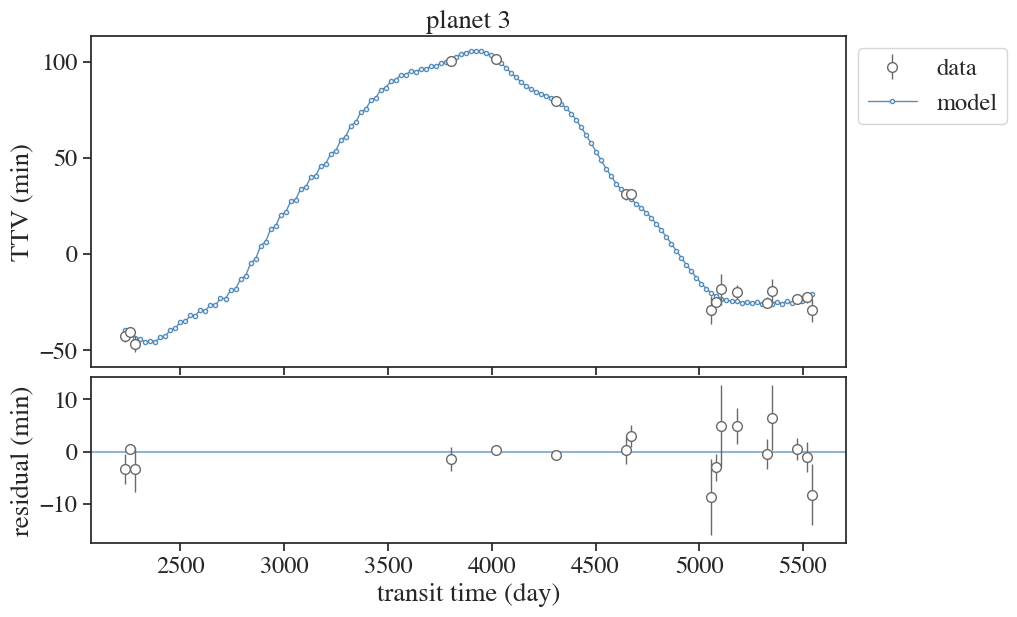

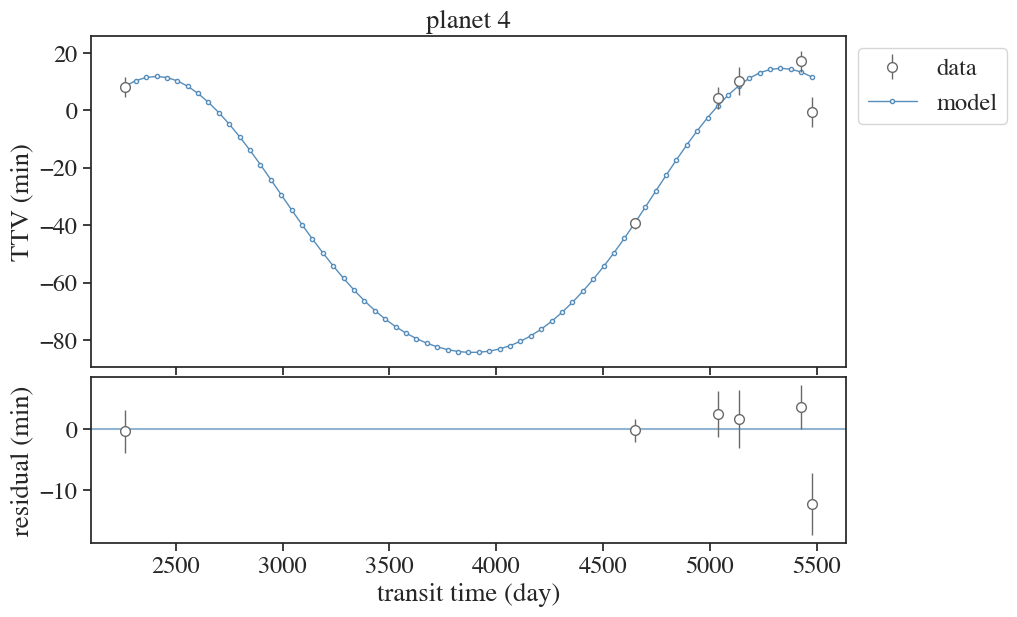

In [6]:
popt = ttv_optim_curve_fit(jttv, param_bounds)

### check precision & residual distribution

In [7]:
tc, tc_precise = jttv.check_timing_precision(popt)

# fractional energy error (symplectic, dt=2.50e-01): 2.04e-08
# fractional energy error (symplectic, dt=8.25e-03): 2.68e-11
# max difference in tc: 3.17e-04 days (27.38 sec)


sample: 100%|██████████| 1000/1000 [00:00<00:00, 1130.68it/s, 3 steps of size 4.20e-01. acc. prob=0.88]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      lndf      1.74      0.73      1.67      0.66      2.93    122.99      1.03
     lnvar      0.41      0.31      0.42     -0.06      0.89    170.22      1.02

Number of divergences: 0


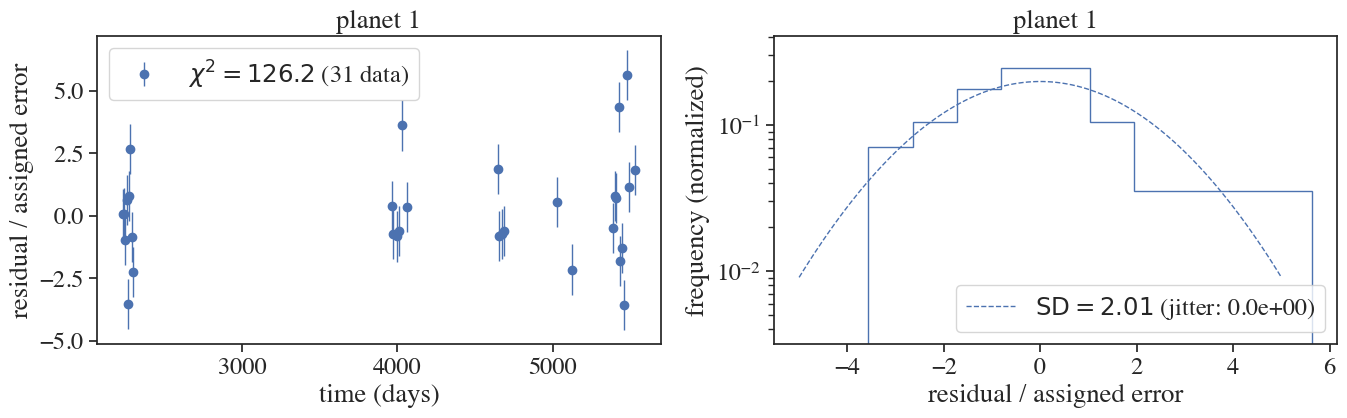

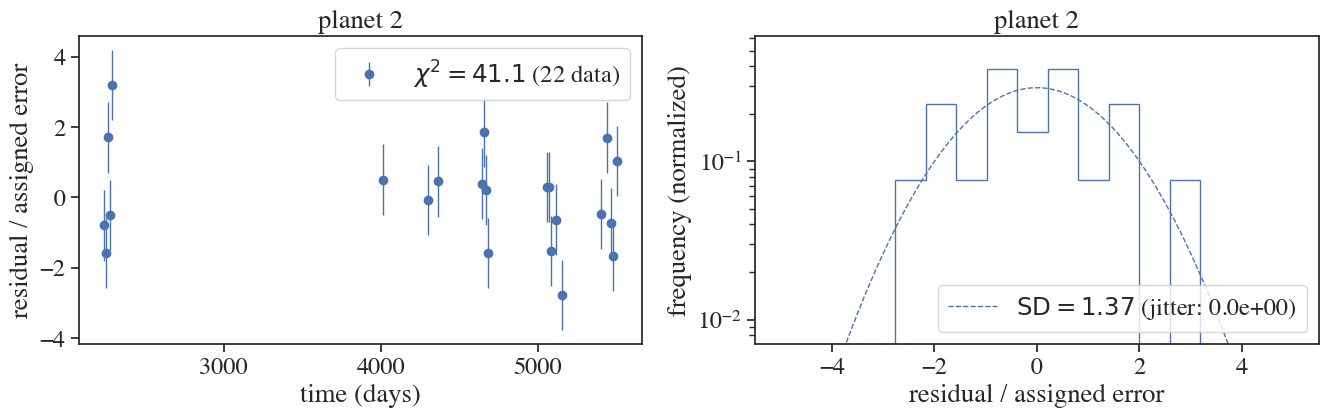

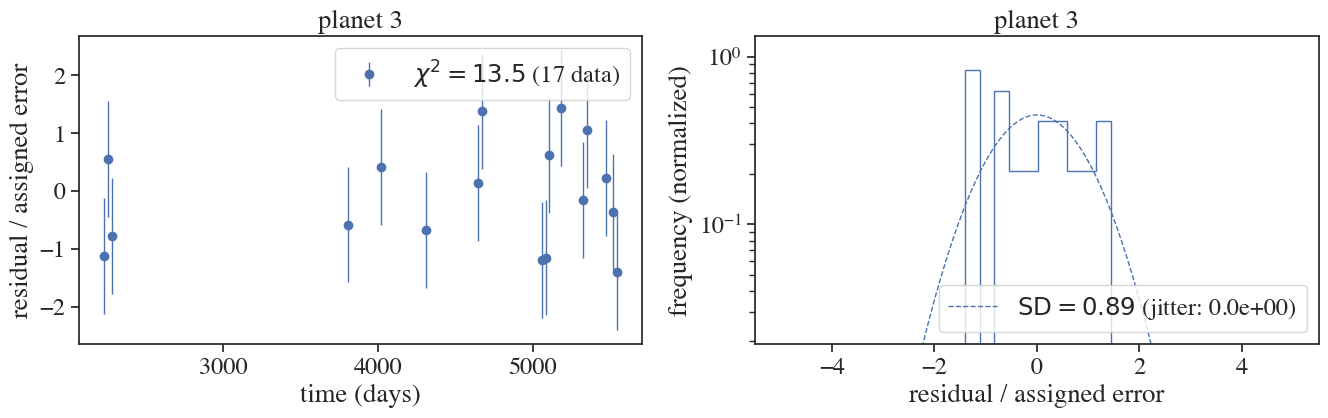

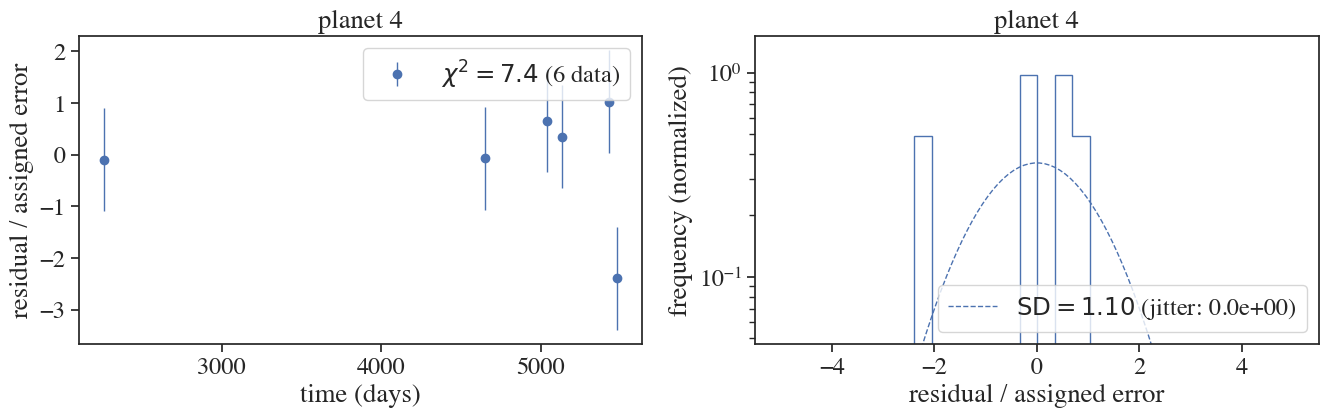

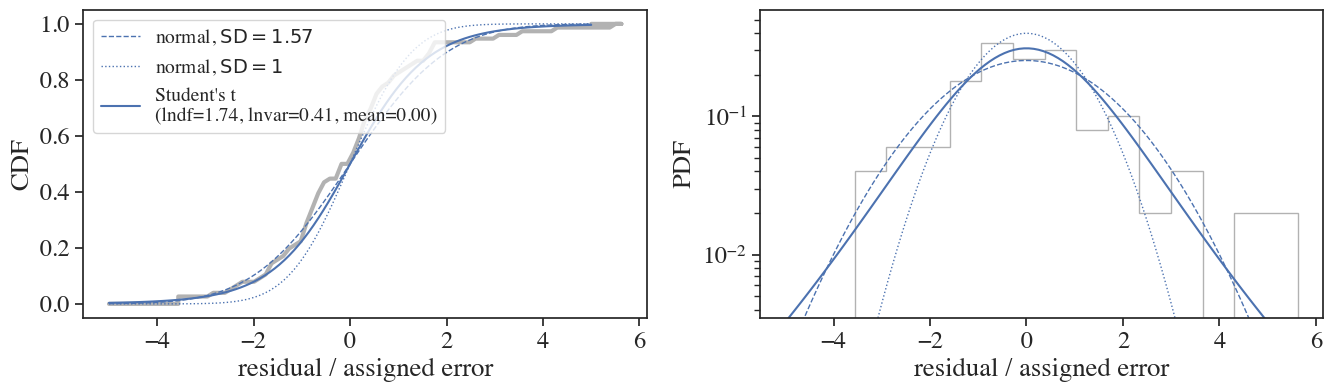

In [8]:
pdic_normal, pdic_student = jttv.check_residuals(popt)

### setup & run HMC

In [9]:
def model_student(sample_keys, param_bounds, uniform_ecc=True, eps=1e-4, df_min=0.5, df_max=100., var_min=0.1, var_max=10.):
    """numpyro model for scaled parameters"""
    par = {}

    # sample parameters from priors
    for key in sample_keys:
        par[key] = numpyro.sample(key, dist.Uniform(param_bounds[key][0], param_bounds[key][1]))
    if "pmass" not in sample_keys:
        par["pmass"] = numpyro.deterministic("pmass", jnp.exp(par["lnpmass"]))
    
    # Jacobian for uniform ecc prior
    # eps is introduced to prevent the log singularity at e=0; a smaller value can be used if needed
    if uniform_ecc:
        ecc = numpyro.deterministic("ecc", jnp.sqrt(par['ecosw']**2 + par['esinw']**2))
        numpyro.factor("eprior", -jnp.log(ecc + eps))

    # compute transit times
    tcmodel, ediff = jttv.get_transit_times_obs(par)
    numpyro.deterministic("ediff", ediff)
    numpyro.deterministic("tcmodel", tcmodel)
    normres = numpyro.deterministic("normres", (jttv.tcobs_flatten - tcmodel) / jttv.errorobs_flatten)
    
    # StudentT likelihood
    lndf = numpyro.sample("lndf", dist.Uniform(jnp.log(df_min), jnp.log(df_max)))
    lnvar = numpyro.sample("lnvar", dist.Uniform(jnp.log(var_min), jnp.log(var_max)))
    df = numpyro.deterministic("df", jnp.exp(lndf))
    v1 = numpyro.deterministic("v1", jnp.exp(lnvar))
    numpyro.sample("obs", dist.StudentT(scale=jnp.sqrt(v1), df=df), obs=normres)

In [10]:
# physical parameters to sample from
sample_keys = ["ecosw", "esinw", "lnpmass", "period", "tic"]

In [11]:
# initialize inverse mass matrix using parameter covariance
# this part can be skipped; in that case just pass dense_mass=True in the next cell
info = information_from_model_independent_normal(model=model_student, model_args=(sample_keys, param_bounds), keys=sample_keys, param_space="unconstrained",
                                                 pdic=popt, mu_name='tcmodel', observed=jttv.tcobs_flatten, sigma_sd=jttv.errorobs_flatten)

In [14]:
dense_mass = [tuple(sample_keys)] + [tuple(['lndf', 'lnvar'])]
parameter_cov_unconstrained = jnp.linalg.inv(info['fisher'])
inverse_mass_matrix = {dense_mass[0]: parameter_cov_unconstrained, dense_mass[1]: jnp.diag(jnp.array([pdic_student['lndf_scale']**2, pdic_student['lnvar_scale']**2]))}

In [15]:
popt['lndf'] = pdic_student['lndf_loc']
popt['lnvar'] = pdic_student['lnvar_loc']

In [16]:
kernel = NUTS(model_student, 
            init_strategy=init_to_value(values=popt), 
            dense_mass=dense_mass,
            inverse_mass_matrix=inverse_mass_matrix,
            max_tree_depth=11, # increase if num_steps keep hitting 2**max_tree_depth - 1
            target_accept_prob=0.7, # increase if there are many divergences
            regularize_mass_matrix=True, # set True if there are many divergences or if sampling breaks
            )

In [17]:
mcmc = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=num_chains)

In [18]:
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, sample_keys, param_bounds, extra_fields=('potential_energy', 'num_steps', 'adapt_state'))

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [19]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  ecosw[0]     -0.00      0.01      0.00     -0.01      0.01   1147.36      1.00
  ecosw[1]     -0.00      0.00     -0.00     -0.01      0.00   1257.54      1.00
  ecosw[2]      0.01      0.00      0.01     -0.00      0.01   1230.87      1.00
  ecosw[3]      0.00      0.01      0.00     -0.02      0.02   1109.26      1.00
  esinw[0]      0.00      0.01      0.00     -0.01      0.02   1458.73      1.00
  esinw[1]     -0.00      0.01     -0.00     -0.01      0.01   1422.18      1.00
  esinw[2]      0.01      0.01      0.01     -0.00      0.02    338.24      1.01
  esinw[3]      0.00      0.01      0.00     -0.02      0.02   1112.75      1.00
      lndf      2.54      0.99      2.47      1.03      4.20   1177.54      1.00
lnpmass[0]    -11.27      0.14    -11.24    -11.46    -11.08    821.04      1.01
lnpmass[1]    -11.05      0.14    -11.01    -11.23    -10.86    827.39      1.01
lnpmass[2]    -10.70      0

### save chains

In [20]:
idata = az.from_numpyro(mcmc)
idata.to_json("v1298tau_ttv_student.json")

'v1298tau_ttv_student.json'

array([[<Axes: title={'center': 'n_steps'}>,
        <Axes: title={'center': 'n_steps'}>]], dtype=object)

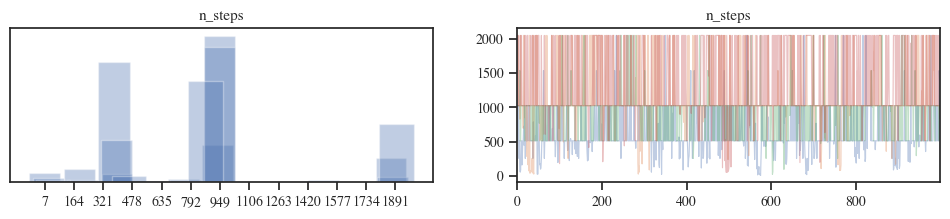

In [21]:
az.plot_trace(idata.sample_stats, var_names=['n_steps'], compact=False)

### plot models drawn from posterior 

In [22]:
samples = mcmc.get_samples()
means, stds = jttv.sample_means_and_stds(samples)

/Users/k_masuda/miniforge3/envs/thunkrt/lib/python3.12/site-packages/jnkepler/jaxttv/jaxttv.py:531: UserWarning: using t0 and P from a linear fit to the observed transit times.
  warnings.warn(


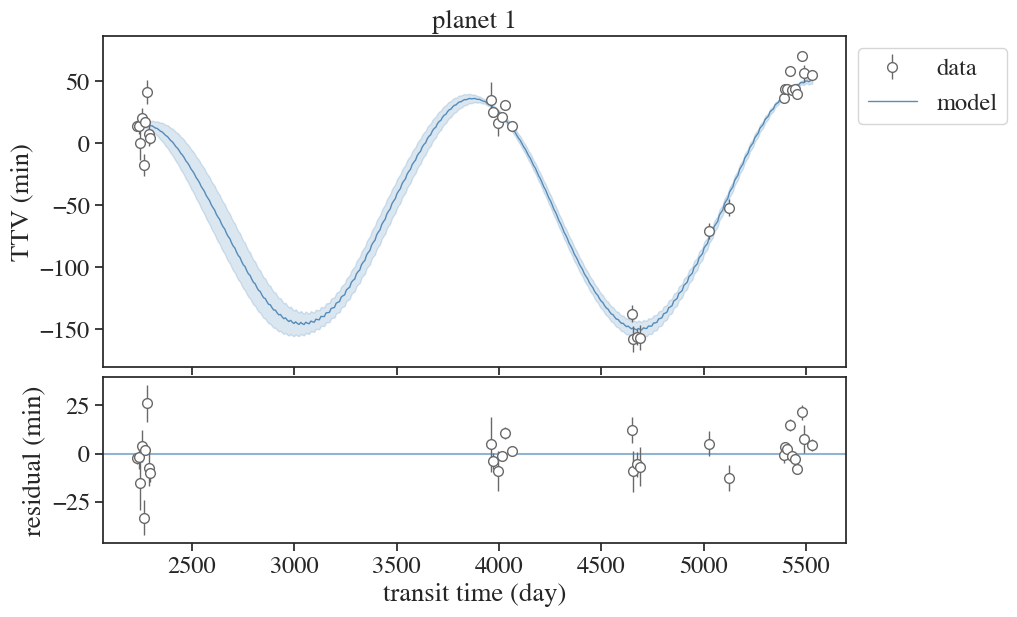

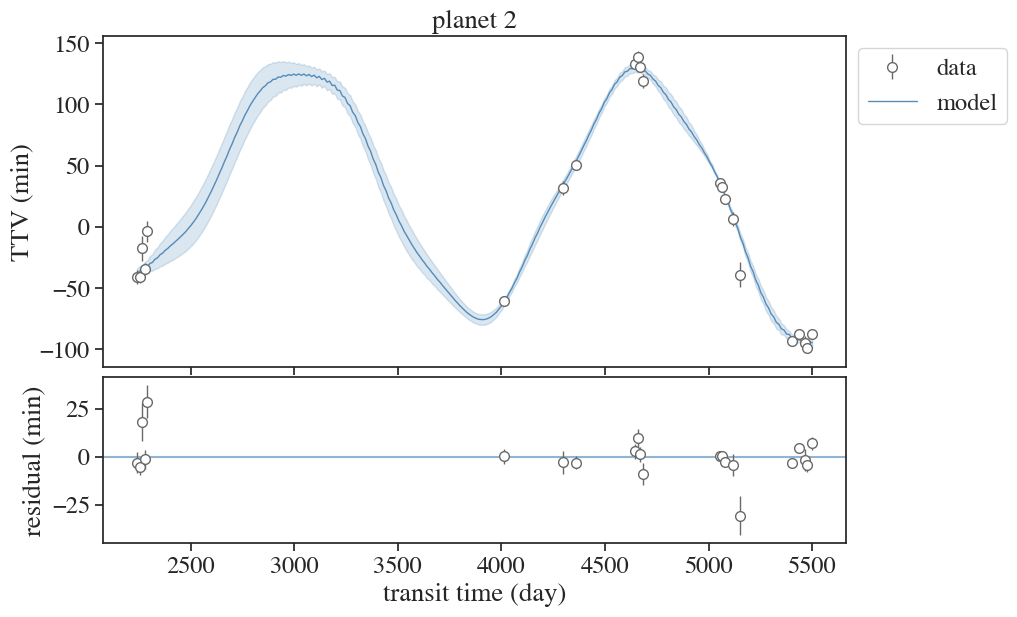

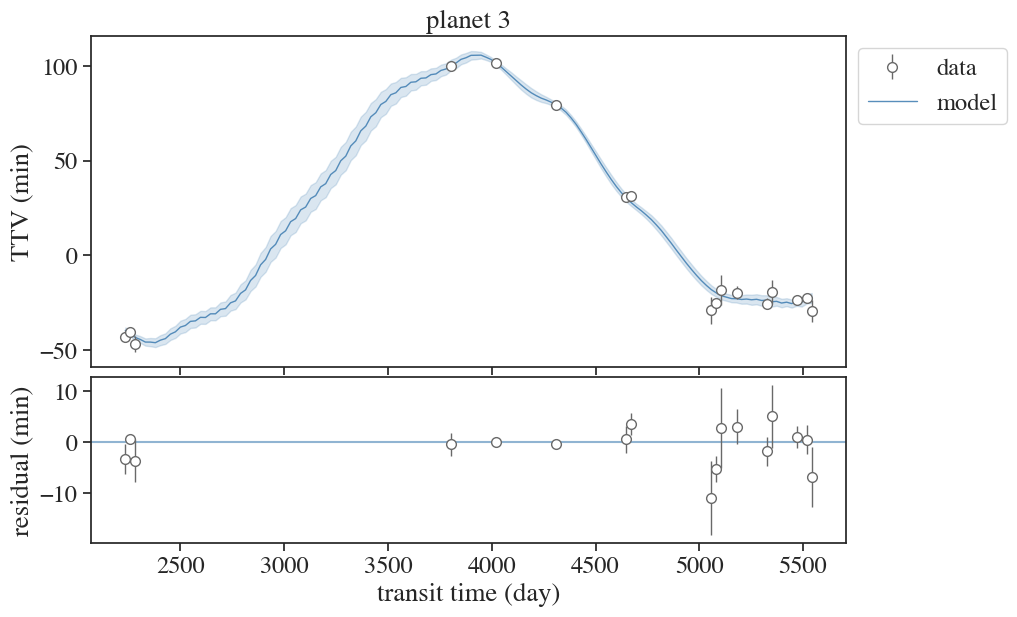

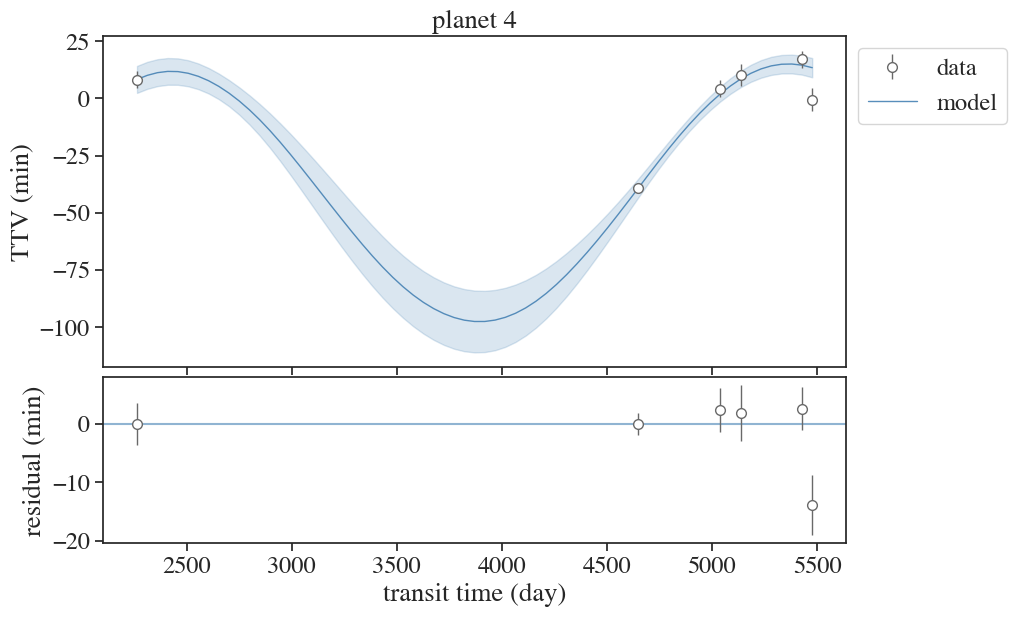

In [23]:
jttv.plot_model(means, tcmodelunclist=stds)

### trace and corner plots

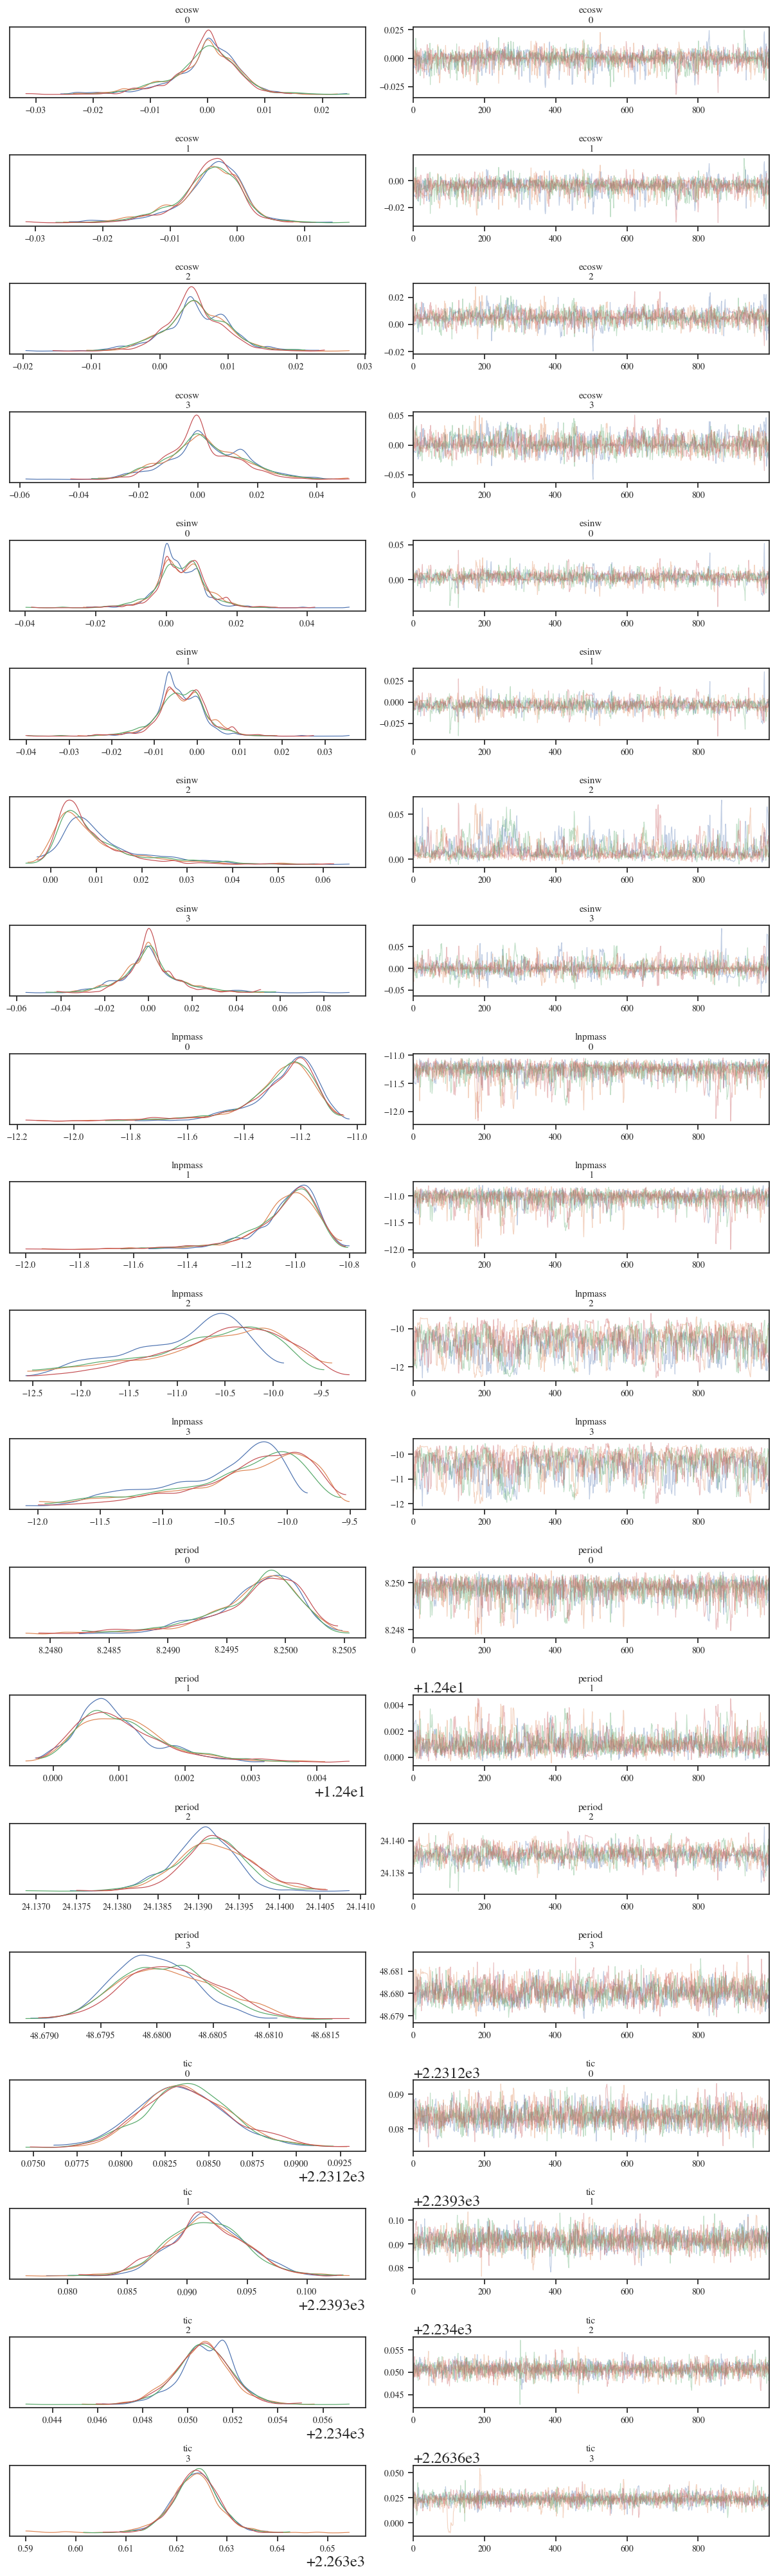

In [24]:
fig = az.plot_trace(idata, var_names=sample_keys, compact=False)
plt.tight_layout(pad=0.2)

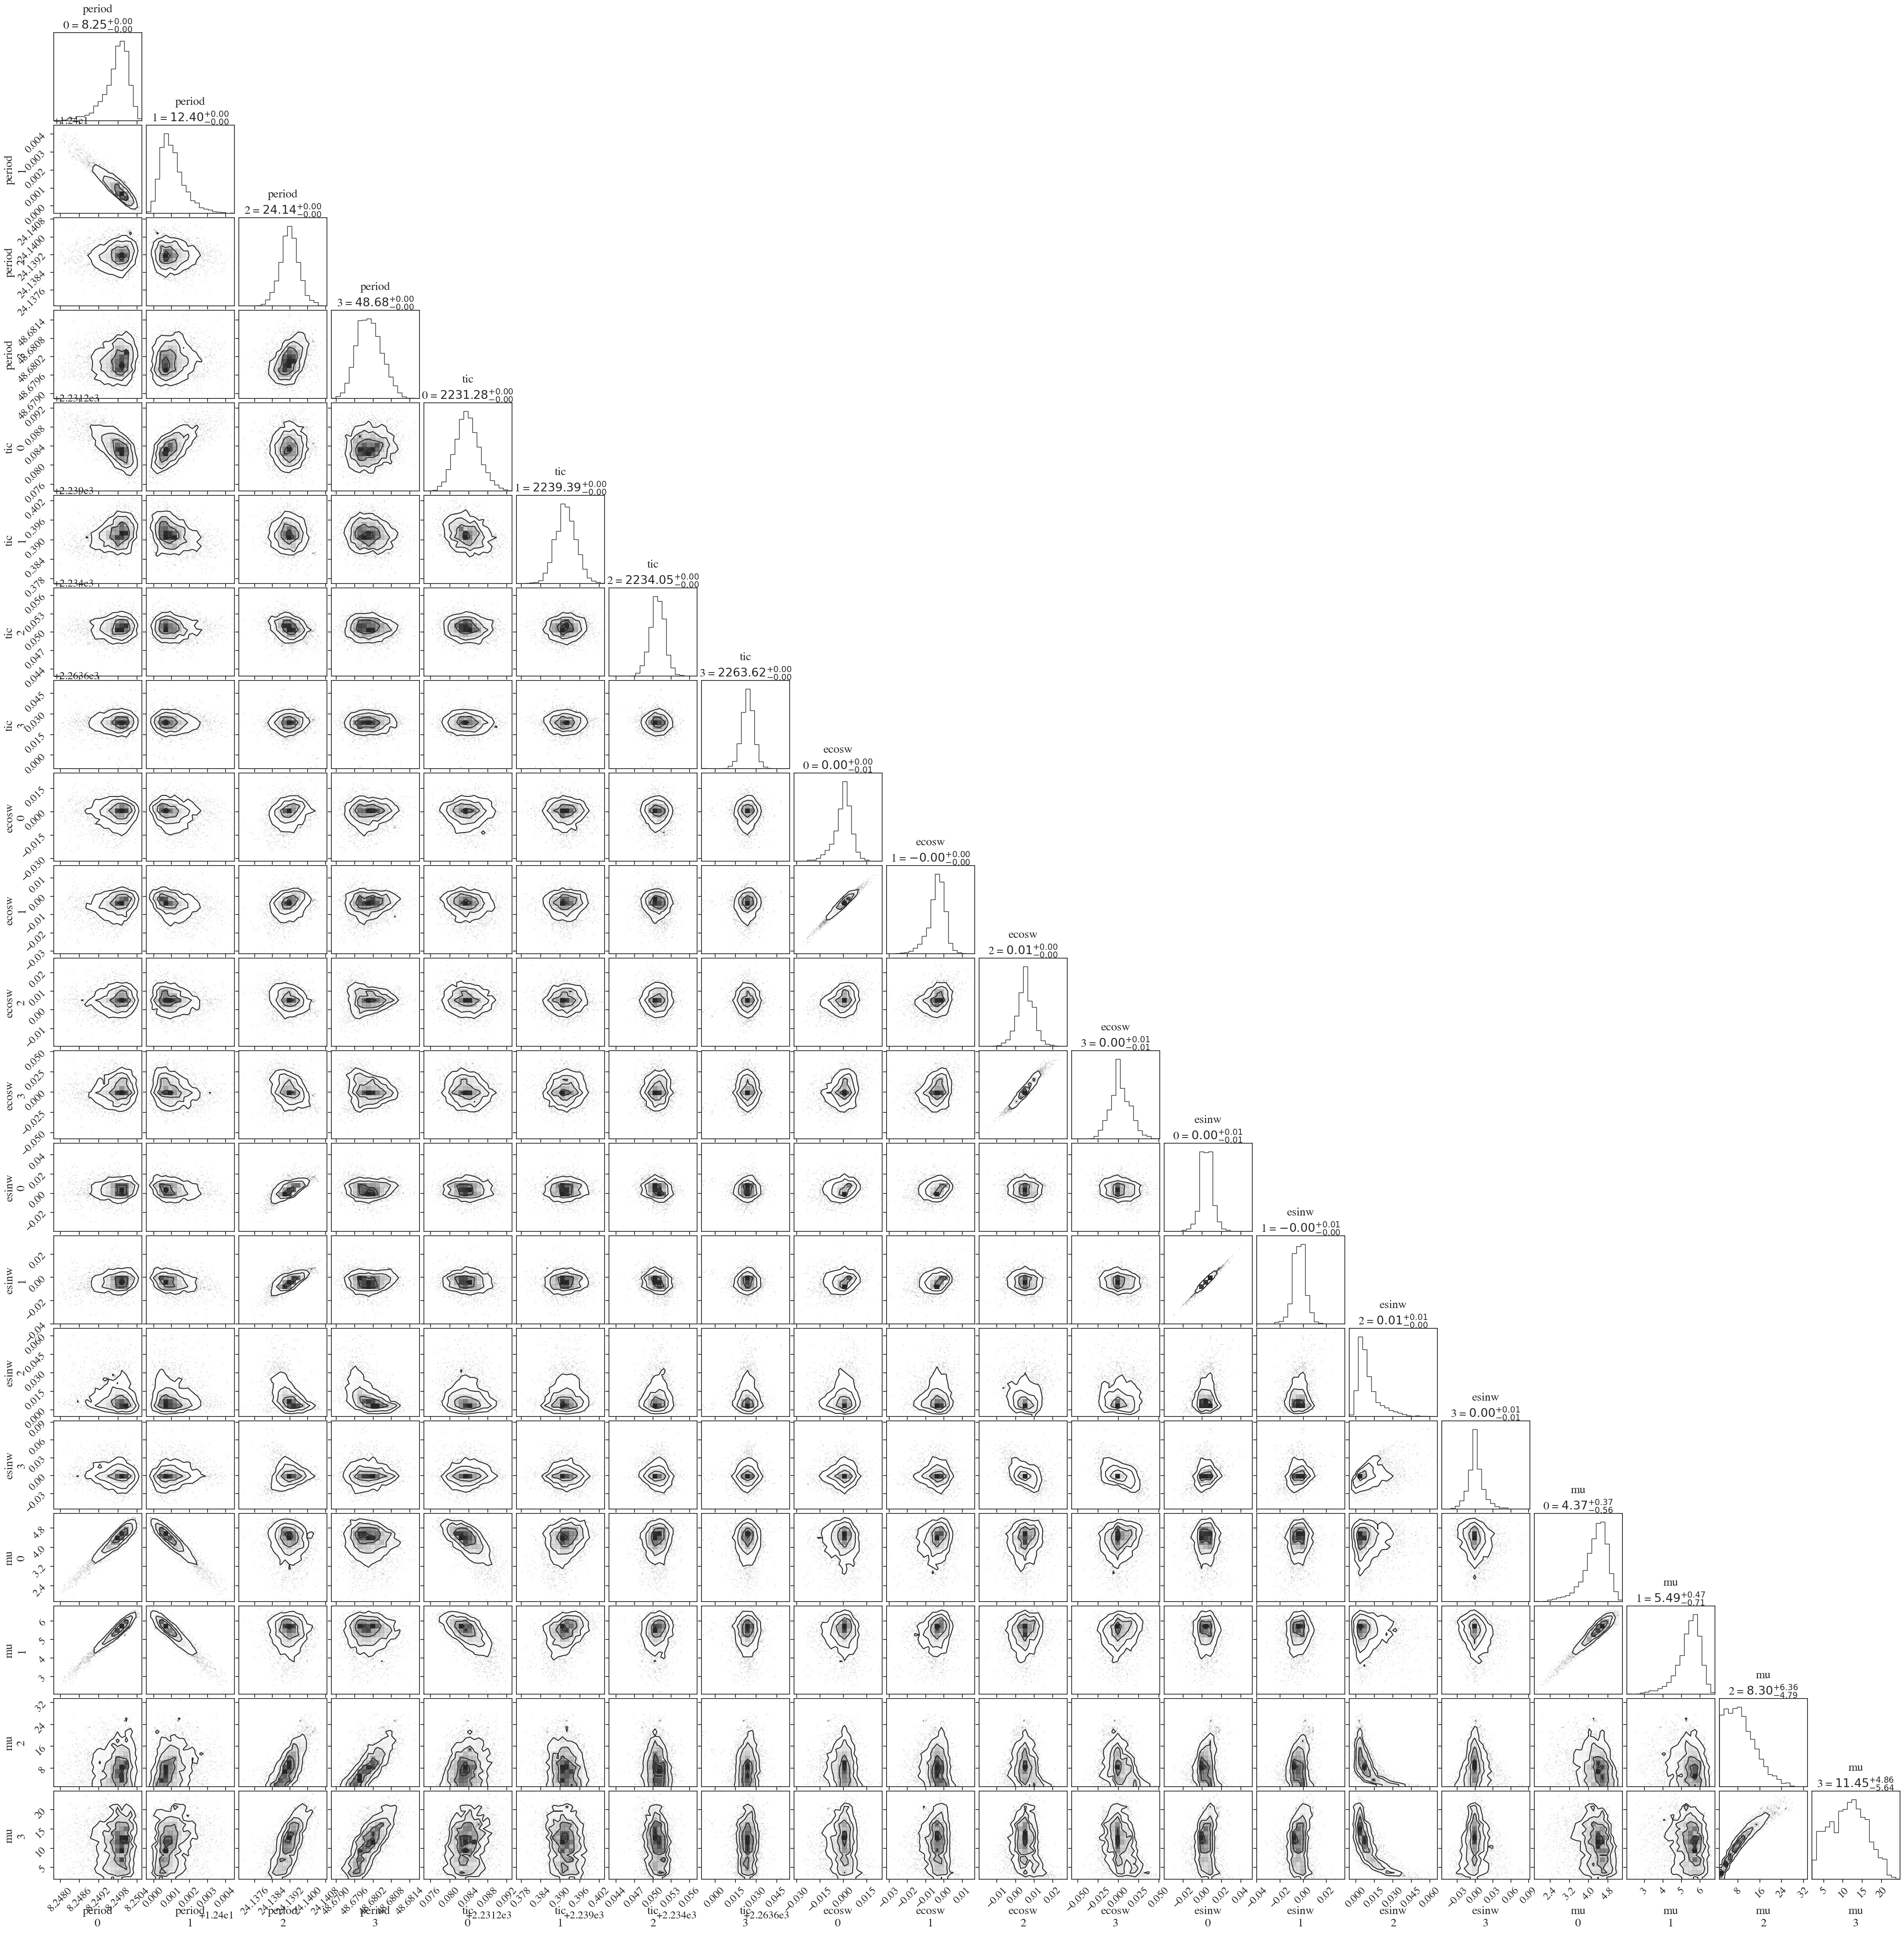

In [26]:
idata.posterior['mu'] = idata.posterior['pmass'] / 3.003e-6 # Earth mass
names = ["period", "tic", "ecosw", "esinw", "mu"]
fig = corner.corner(idata, var_names=names, show_titles=True)

### Resampling 

The above analysis assumes log-uniform prior for planet's mass and uniform prior for eccentricity. 

Here we reweight the sample so that the prior for eccentricity is log-uniform for comparison with the analysis in [Livingston et al. (2026)](https://www.nature.com/articles/s41586-025-09840-z).

In [27]:
import dill
import matplotlib.lines as mlines

def get_loge_weights(samples, e_lower_bound=1e-3):
    emin = np.min(samples['ecc'], axis=1) # minimum e among all planets
    eccarr = np.array(samples['ecc'])
    logweights = np.sum(-np.log(eccarr), axis=1)
    logweights -= np.max(logweights)
    weights = np.exp(logweights)
    weights = np.where(emin < e_lower_bound, 0, weights)
    return weights


def resample_to_loge(samples, e_lower_bound=1e-3, seed=123):
    num_original_samples = len(samples['pmass'])
    weights = get_loge_weights(samples, e_lower_bound=e_lower_bound)
    weights /= np.sum(weights)
    
    np.random.seed(seed)
    idx_resample = np.random.choice(np.arange(num_original_samples), p=weights, size=num_original_samples)

    samples_out = {}
    for key in samples.keys():
        samples_out[key] = samples[key][idx_resample]
    
    return samples_out, weights

def to_arr(samples):
    if 'pmass' in samples.keys():
        return np.c_[samples['pmass']/3.003e-6, np.log(samples['ecc'])]
    else:
        return np.c_[samples['mass']/3.003e-6, np.log(samples['ecc'])]

In [28]:
samples_reweighted, weights = resample_to_loge(samples)

In [43]:
def load_samples_npz(path):
    with np.load(path) as f:
        return {k: f[k] for k in f.files}

smp_l26 = load_samples_npz("v1298tau_samples.npz")

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\l'
<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\l'
/var/folders/8l/c_0pxd512sd6bbskytr1ccn80000gn/T/ipykernel_49347/3071773699.py:1: SyntaxWarning: invalid escape sequence '\s'
  labels = np.array([f'$M_{i}/M_\star$ ($M_\oplus/M_\star$)' for i in range(1,5)] + [f'$\ln e_{i}$' for i in range(1,5)]).ravel()
/var/folders/8l/c_0pxd512sd6bbskytr1ccn80000gn/T/ipykernel_49347/3071773699.py:1: SyntaxWarning: invalid escape sequence '\l'
  labels = np.array([f'$M_{i}/M_\star$ ($M_\oplus/M_\star$)' for i in range(1,5)] + [f'$\ln e_{i}$' for i in range(1,5)]).ravel()


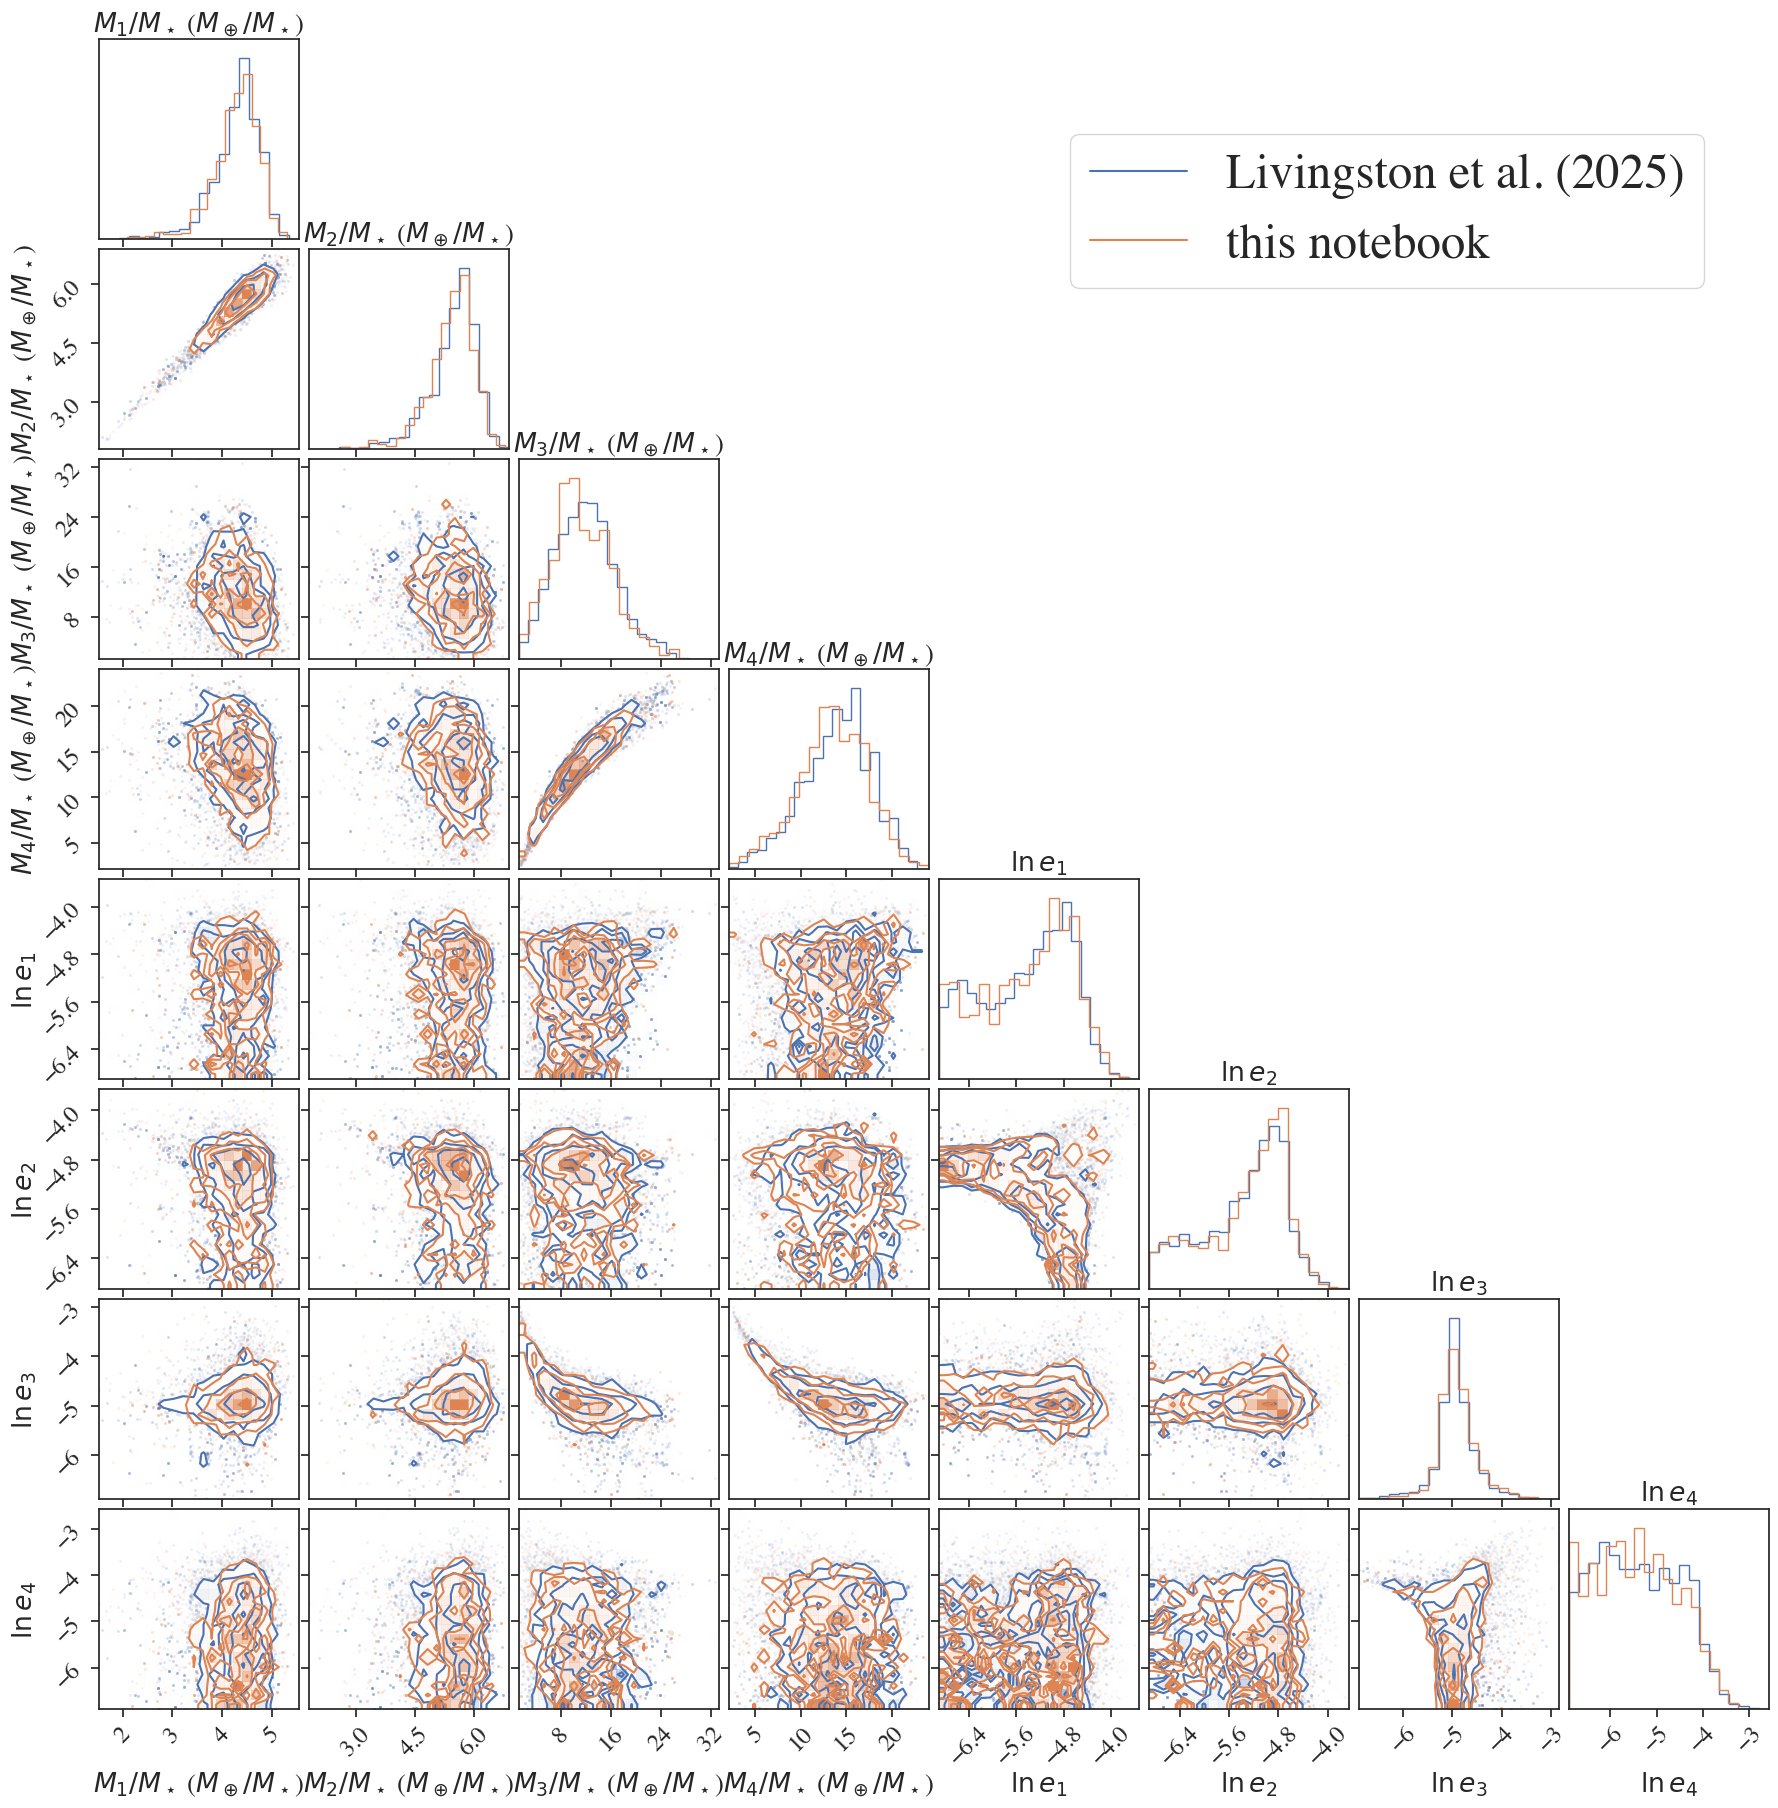

In [ ]:
labels = np.array([f'$M_{i}/M_\star$ ($M_\oplus/M_\star$)' for i in range(1,5)] + [f'$\ln e_{i}$' for i in range(1,5)]).ravel()
names = ["Livingston et al. (2026)", "this notebook"]
ndim = len(labels)
fig_ = corner.corner(to_arr(smp_l26), labels=labels, show_titles=True, bins=20, color='C0', title_fmt=None, hist_kwargs={"density": True})
fig = corner.corner(to_arr(samples_reweighted), labels=labels, show_titles=True, bins=20, color='C1', title_fmt=None, hist_kwargs={"density": True}, fig=fig_)
handles = []
for i, name in enumerate(names):
    handles.append(mlines.Line2D([], [], color='C%d'%i, label=name))
plt.legend(handles=handles, bbox_to_anchor=(0.8, ndim), fontsize=35);